In [2]:
%load_ext autoreload
%autoreload 2

from ble import get_ble_controller
from base_ble import LOG
from cmd_types import CMD
import time
import numpy as np

LOG.propagate = False

from matplotlib import pyplot as plt
import random
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# disconnect from Artemis
ble.disconnect()

2023-05-07 22:16:17,674 | INFO     |: Disconnected from 17C0176F-95E8-439F-A4DD-EF7D3F71062E


In [57]:
# connect to Artemis

# Get ArtemisBLEController object
ble = get_ble_controller()

# Connect to the Artemis Device
ble.connect()

2023-05-08 16:20:10,541 | INFO     |: Looking for Artemis Nano Peripheral Device: C0:83:D5:66:86:3C
2023-05-08 16:20:13,112 | INFO     |: Connected to C0:83:D5:66:86:3C


In [38]:
# test sending and receiving

ble.send_command(CMD.PING, "")

s = ble.receive_string(ble.uuid['RX_STRING'])
print(s)

PONG


In [5]:
# STATIC --- read and aggregate time, pitch, roll, yaw, TOF#1, TOF#2, leftPWM, rightPWM

def fft_callback(uuid, data):
    
    reading = (ble.bytearray_to_string(data)).split('|')
    #print(reading)
    
    for count in range(entries):
        try:
            nextPos = count*8
            time.append((reading[nextPos]))
            pitchC.append((reading[nextPos+1]))
            rollC.append((reading[nextPos+2]))
            yaw.append((reading[nextPos+3]))
            ONEDist.append((reading[nextPos+4]))
            TWODist.append((reading[nextPos+5]))
            leftPWM.append((reading[nextPos+6]))
            rightPWM.append((reading[nextPos+7]))
        except (IndexError,ValueError):
            continue
        
    
entries = 3
time = []
pitchC = []
rollC = []
yaw = []
ONEDist = []
TWODist = []
leftPWM = []
rightPWM = []

ble.start_notify(ble.uuid['RX_STRING'], fft_callback)
ble.send_command(CMD.TIMED_PID_DATA, "")

In [54]:
ble.send_command(CMD.UPDATE_KP, "0.20")

In [61]:
# MOTION --- PID to given distance and read and aggregate time, pitch, roll, yaw, TOF#1, TOF#2, leftPWM, rightPWM

def fft_callback(uuid, data):
    
    reading = (ble.bytearray_to_string(data)).split('|')
    #print(reading)
    
    for count in range(entries):
        try:
            nextPos = count*7
            time.append((reading[nextPos]))
            pitchC.append((reading[nextPos+1]))
            rollC.append((reading[nextPos+2]))
            yaw.append((reading[nextPos+3]))
            ONEDist.append((reading[nextPos+4]))
            error.append((reading[nextPos+5]))
            speed.append((reading[nextPos+6]))
        except (IndexError,ValueError):
            continue
        
    
entries = 3
time = []
pitchC = []
rollC = []
yaw = []
ONEDist = []
error = []
speed = []

ble.start_notify(ble.uuid['RX_STRING'], fft_callback)
ble.send_command(CMD.TOF_PID, "304")

In [21]:
# STEP --- PID to given distance and read and aggregate time, pitch, roll, yaw, TOF#1, TOF#2, leftPWM, rightPWM

def fft_callback(uuid, data):
    
    reading = (ble.bytearray_to_string(data)).split('|')
    #print(reading)
    
    for count in range(entries):
        try:
            nextPos = count*7
            time.append((reading[nextPos]))
            pitchC.append((reading[nextPos+1]))
            rollC.append((reading[nextPos+2]))
            yaw.append((reading[nextPos+3]))
            ONEDist.append((reading[nextPos+4]))
            error.append((reading[nextPos+5]))
            speed.append((reading[nextPos+6]))
        except (IndexError,ValueError):
            continue
        
    
entries = 3
time = []
pitchC = []
rollC = []
yaw = []
ONEDist = []
error = []
speed = []

ble.start_notify(ble.uuid['RX_STRING'], fft_callback)
ble.send_command(CMD.STEP, "")

In [92]:
print(speed)

['-76', '-76', '-76', '193', '193', '193', '197', '197', '197', '200', '200', '200', '201', '201', '201', '201', '203', '203', '203', '203', '205', '205', '205', '205', '205', '205', '204', '204', '204', '204', '201', '201', '201', '200', '200', '200', '197', '197', '197', '196', '196', '196', '192', '192', '192', '192', '192', '189', '189', '189', '189', '185', '185', '185', '182', '182', '182', '176', '176', '176', '170', '170', '170', '164', '164', '164', '164', '159', '159', '159', '159', '155', '155', '155', '155', '149', '149', '149', '143', '143', '143', '136', '136', '136', '136', '130', '130', '130', '124', '124', '124', '124', '124', '120', '120', '120', '120', '120', '120', '120', '120', '120', '-76', '-76', '-76', '-76', '-76', '94', '94', '94', '94', '94', '85', '85', '85', '85', '85', '77', '77', '77', '77', '77', '77', '67', '67', '67', '67', '67', '67', '51', '51', '51', '51', '51', '51', '50', '50', '50', '50', '50', '50', '0', '0', '0', '0', '0', '0', '0', '0', '0', '

In [62]:
# stop notifications from this characteristic

ble.stop_notify(ble.uuid['RX_STRING'])

In [ ]:
intDist = []
intPWM = []
kf_output = []

for item in range(len(ONEDist)):
    intDist.append(int(ONEDist[item]))
    intPWM.append(int(speed[item]))

# initializing Kalman Filter

# sampling, drag, and momentum
SecPerSample = 0.0122
d = 0.000521
m = 0.000283

# A,B,C matrices and discretized 
A = np.array([[0,1],[0,-d/m]])
B = np.array([[0],[1/m]])
C = np.array([[1,0]])

A_disc = np.eye(2) + SecPerSample * A
B_disc = SecPerSample * B
C=np.array([[1,0]])

# ballpark variances, process variance
posSigma = np.sqrt(10**2/SecPerSample)
speedSigma = np.sqrt(10**2/SecPerSample)
sensorSigma = 1.14

sigma_u=np.array([[posSigma**2,0],[0,speedSigma**2]])
sigma_z=np.array([[sensorSigma**2]])

print(A_disc)
print(B_disc)
print(C)

# initial states
x = np.array([[-intDist[0]],[0]])
sig = np.array([[10,0],[0,10]])
    

In [ ]:
def kf(x,u,sig,y):
    
    x_p = A_disc.dot(x) + B_disc.dot(u)                     
    sig_p = A_disc.dot(sig.dot(A_disc.transpose())) + sigma_u 
    
    y_m = y-C.dot(x_p)
    sig_m = C.dot(sig_p.dot(C.transpose())) + sigma_z
    
    kf_gain = sig_p.dot(C.transpose().dot(np.linalg.inv(sig_m)))

    x_n   = x_p + kf_gain.dot(y_m)
    sig_n = (np.eye(2) - kf_gain.dot(C)).dot(sig_p)
    return x_n, sig_n

In [ ]:
kf_output = []
for dist, pwm in zip(intDist, intPWM):
    x, sig = kf(x, pwm/120, sig, dist)
    kf_output.append(x[0][0])

In [ ]:
# Plot distance measurement data
intTime = [eval(t)/1000 for t in time]
intDist = [eval(t) for t in speed]
plt.scatter(intTime, intDist, label = "PWM")
#plt.scatter(intTime, kf_output, label = "Kalman Filtered")

plt.title("Time vs PWM")
plt.xlabel("Time (s)")
plt.ylabel("PWM")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)
# plt.ylim((0,-6000))


In [17]:
# KF --- PID to given distance and read and aggregate time, pitch, roll, yaw, TOF#1, TOF#2, leftPWM, rightPWM

def fft_callback(uuid, data):
    
    reading = (ble.bytearray_to_string(data)).split('|')
    #print(reading)
    
    for count in range(entries):
        try:
            nextPos = count*7
            time.append((reading[nextPos]))
            pitchC.append((reading[nextPos+1]))
            rollC.append((reading[nextPos+2]))
            yaw.append((reading[nextPos+3]))
            ONEDist.append((reading[nextPos+4]))
            kfdist.append((reading[nextPos+5]))
            speed.append((reading[nextPos+6]))
        except (IndexError,ValueError):
            continue
        
    
entries = 3
time = []
pitchC = []
rollC = []
yaw = []
ONEDist = []
kfdist = []
speed = []

ble.start_notify(ble.uuid['RX_STRING'], fft_callback)
ble.send_command(CMD.KF_PID, "304")

ValueError: Characteristic notifications already started

In [33]:
# STUNT --- step to given distance and read and aggregate time, pitch, roll, yaw, TOF#1, TOF#2, leftPWM, rightPWM

def fft_callback(uuid, data):
    
    reading = (ble.bytearray_to_string(data)).split('|')
    #print(reading)
    
    for count in range(entries):
        try:
            nextPos = count*7
            time.append((reading[nextPos]))
            pitchC.append((reading[nextPos+1]))
            rollC.append((reading[nextPos+2]))
            yaw.append((reading[nextPos+3]))
            ONEDist.append((reading[nextPos+4]))
            error.append((reading[nextPos+5]))
            speed.append((reading[nextPos+6]))
        except (IndexError,ValueError):
            continue
        
entries = 3
time = []
pitchC = []
rollC = []
yaw = []
ONEDist = []
error = []
speed = []

ble.start_notify(ble.uuid['RX_STRING'], fft_callback)
ble.send_command(CMD.STUNT, "")

In [47]:
print(speed)

['-76', '-76', '-76', '-76', '-76', '149', '149', '149', '159', '159', '159', '159', '157', '157', '157', '157', '157', '157', '157', '152', '152', '152', '147', '147', '147', '147', '138', '138', '138', '124', '124', '124', '110', '110', '110', '96', '96', '96', '96', '96', '82', '82', '82', '64', '64', '64', '50', '50', '50', '50', '50', '50', '50', '50', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '-50', '-50', '-50', '-50', '-52', '-52', '-52', '-69', '-69', '-69', '-73', '-73', '-73', '-73', '-73', '-73', '-73', '-73', '-73', '-67', '-67', '-67', '-60', '-60', '-60', '-60', '-60', '-56', '-56', '-56', '-56', '-56', '-51', '-51', '-51', '-50', '-50', '-50', '-50', '-50', '-50', '-50', '-50', '-50', '-50', '-50', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

In [64]:
# stop notifications from this characteristic

ble.stop_notify(ble.uuid['RX_STRING'])

ValueError: Characteristic notification never started

2023-05-08 16:22:50,621 | INFO     |: Disconnected from 17C0176F-95E8-439F-A4DD-EF7D3F71062E


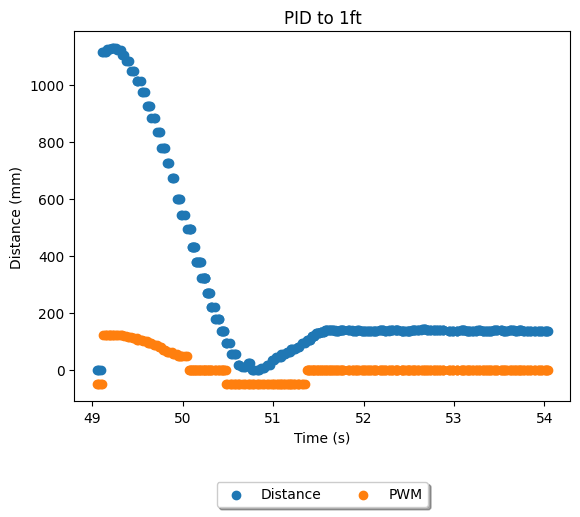

In [63]:
import random

# Plot distance measurement data
intTime = [eval(t)/1000 for t in time]
intDist = [eval(i) for i in ONEDist]
intSpeed = [eval(i) for i in speed]
# intkf = [eval(i)+random.randint(3, 20) for i in kfdist]
plt.scatter(intTime, intDist, label = "Distance")
plt.scatter(intTime, intSpeed, label = "PWM")

plt.title("PID to 1ft")
plt.xlabel("Time (s)")
plt.ylabel("Distance (mm)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=5)
# plt.ylim((0,-6000))
